In [1]:
import copy
import pandas as pd
import numpy as np
import string
import torch
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader, random_split, TensorDataset

import nltk
from nltk.tokenize import word_tokenize

import torch.nn as nn
import torch.optim as optim

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Load Dataset

In [2]:
path = '/content/balanced_sentiment 400.0k.csv'
df = pd.read_csv(path)

df.head(5)

,sentiment,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [3]:
df.isna().sum()

,0
sentiment,0
text,0


In [4]:
df['sentiment'].value_counts()

,count
sentiment,
0,200000
1,200000


# Lowercase

In [5]:
def lowercase(df):
    df['text'] = df['text'].str.lower()
    return df

# Assuming df is already defined and loaded with data
df = lowercase(df)
print(df.head(5))


   sentiment                                               text
0          0  @switchfoot http://twitpic.com/2y1zl - awww, t...
1          0  is upset that he can't update his facebook by ...
2          0  @kenichan i dived many times for the ball. man...
3          0    my whole body feels itchy and like its on fire 
4          0  @nationwideclass no, it's not behaving at all....


# Punctuation

In [6]:
def punctuation(df):
    # Define a translation table that maps each punctuation character to None
    translator = str.maketrans('', '', string.punctuation)

    df['text'] = df['text'].apply(lambda x: x.translate(translator))

    return df

df = punctuation(df)
print(df.head(5))

   sentiment                                               text
0          0  switchfoot httptwitpiccom2y1zl  awww thats a b...
1          0  is upset that he cant update his facebook by t...
2          0  kenichan i dived many times for the ball manag...
3          0    my whole body feels itchy and like its on fire 
4          0  nationwideclass no its not behaving at all im ...


# Remove stopwords

In [7]:
 def ensure_nltk_data():
     try:
         stop_words = set(stopwords.words('english'))
     except LookupError:
         nltk.download('stopwords')
         stop_words = set(stopwords.words('english'))

     try:
         nltk.data.find('tokenizers/punkt')
     except LookupError:
         nltk.download('punkt')

 ensure_nltk_data()
 # load the set of stopwords
 stop_words = set(stopwords.words('english'))

 #check if we get stopwords
 a = 0
 for w in stop_words:
     print(w)
     a += 1
     if a == 5:
         break

me
having
above
very
mustn


In [8]:
 def remove_stopwords(cell):
     words = cell.split()
     filtered_words = [w for w in words if w not in stop_words]
     return ' '.join(filtered_words)

 df['text'] = df['text'].apply(remove_stopwords)
 print(df.head(5))

   sentiment                                               text
0          0  switchfoot httptwitpiccom2y1zl awww thats bumm...
1          0  upset cant update facebook texting might cry r...
2          0  kenichan dived many times ball managed save 50...
3          0                   whole body feels itchy like fire
4          0           nationwideclass behaving im mad cant see


In [9]:
df.isna().sum()

,0
sentiment,0
text,0


# Tokenize

In [10]:
def tokenize(cell):
    return word_tokenize(cell)

nltk.download('punkt')

df['text'] = df['text'].apply(tokenize)
print(df.head(5))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


   sentiment                                               text
0          0  [switchfoot, httptwitpiccom2y1zl, awww, thats,...
1          0  [upset, cant, update, facebook, texting, might...
2          0  [kenichan, dived, many, times, ball, managed, ...
3          0            [whole, body, feels, itchy, like, fire]
4          0    [nationwideclass, behaving, im, mad, cant, see]


# Embeddings

In [11]:
file_path_embeddings = '/content/glove.6B.50d.txt'

def load_glove_embeddings(filepath):
    embeddings = {}
    with open(filepath, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            embeddings[word] = vector
    return embeddings

def get_embedding(word, embeddings):
    return embeddings.get(word, None)

embeddings = load_glove_embeddings(file_path_embeddings)


def embed(cell):
    vectors = []
    for t in cell:  # Assuming cell is already a list of tokens
        vector = get_embedding(t, embeddings)
        if vector is not None:
            vectors.append(vector)
    return vectors

df['text'] = df['text'].apply(embed)
df.head(5)

,sentiment,text
0,0,"[[-0.28265, -0.13972, 0.2381, 0.39285, -0.6081..."
1,0,"[[-0.66226, -0.24602, -0.074331, 0.70106, 0.01..."
2,0,"[[-0.45581, -1.1128, 1.0626, -0.65459, 0.42869..."
3,0,"[[0.4355, -0.18377, -0.70186, -0.19652, 1.1405..."
4,0,"[[0.25207, -1.6823, -0.57242, -1.0334, 0.67554..."


# Remove empty rows
Because we performed transformations that my result in empty rows (if no words have corresponding embedding) now is the time to clean the df from those rows

In [12]:
def is_empty_or_nested_empty(cell):
    if isinstance(cell, list):
        if not cell:  # Check if the list itself is empty
            return True
        for item in cell:
            if isinstance(item, list) and not item:  # Check if there are nested empty lists
                return True
    return False

# Apply the function to each cell in the 'text' column
df['is_empty'] = df['text'].apply(is_empty_or_nested_empty)

# Filter the DataFrame to find rows with empty or nested empty lists
empty_rows = df[df['is_empty']]

# Extract the indexes of rows with empty or nested empty lists
empty_rows_indexes = empty_rows.index.tolist()

# Print the indexes of rows with empty or nested empty lists
print("Indexes of rows with empty or nested empty lists:")
print(empty_rows_indexes)

# Optionally, print the count
empty_count = len(empty_rows_indexes)
print(f"\nNumber of rows with empty or nested empty lists: {empty_count}")

Indexes of rows with empty or nested empty lists:
[135, 208, 249, 282, 309, 398, 430, 555, 614, 1011, 1014, 1231, 1343, 1421, 1448, 1468, 1486, 1641, 2225, 2589, 2898, 2973, 3040, 3209, 3467, 3997, 4201, 4233, 4318, 4377, 4508, 4805, 5029, 5284, 5359, 6058, 6171, 6191, 6258, 6374, 6419, 6446, 6474, 7009, 7170, 7310, 7360, 7683, 7790, 7840, 7872, 8076, 8239, 8399, 8415, 8557, 8708, 8709, 8838, 9072, 9170, 9323, 9556, 9599, 9756, 10033, 10149, 10278, 10379, 10625, 10862, 10949, 11074, 11113, 11130, 11240, 11324, 11348, 11367, 11820, 12037, 12092, 12110, 12550, 12674, 12712, 13206, 13232, 13411, 13494, 13546, 13703, 13960, 14003, 14022, 14226, 14470, 14501, 14516, 14552, 14619, 14685, 14777, 14905, 14943, 14989, 15495, 15679, 16074, 16145, 16342, 16417, 16727, 16803, 17071, 17364, 17422, 17433, 17523, 17611, 17854, 18048, 18207, 18303, 18333, 18375, 18658, 18796, 18950, 19154, 19239, 19267, 19362, 19445, 19592, 19611, 19613, 19625, 19689, 19798, 20870, 20880, 20929, 21013, 21143, 21241, 2

In [13]:
df_empty_rows = df.loc[empty_rows_indexes]

# Print the DataFrame with empty or nested empty lists
print("\nDataFrame with rows that contain empty or nested empty lists:")
print(df_empty_rows)


DataFrame with rows that contain empty or nested empty lists:
        sentiment text  is_empty
135             0   []      True
208             0   []      True
249             0   []      True
282             0   []      True
309             0   []      True
...           ...  ...       ...
399603          1   []      True
399674          1   []      True
399868          1   []      True
399893          1   []      True
399911          1   []      True

[3605 rows x 3 columns]


In [14]:
df = df.drop(empty_rows_indexes)

# Drop the helper column 'is_empty'
df = df.drop(columns=['is_empty'])

# Print the cleaned DataFrame
print("Cleaned DataFrame with rows containing empty or nested empty lists removed:")
print(df.head(5))

Cleaned DataFrame with rows containing empty or nested empty lists removed:
   sentiment                                               text
0          0  [[-0.28265, -0.13972, 0.2381, 0.39285, -0.6081...
1          0  [[-0.66226, -0.24602, -0.074331, 0.70106, 0.01...
2          0  [[-0.45581, -1.1128, 1.0626, -0.65459, 0.42869...
3          0  [[0.4355, -0.18377, -0.70186, -0.19652, 1.1405...
4          0  [[0.25207, -1.6823, -0.57242, -1.0334, 0.67554...


In [15]:
len(df)

396395

# Check max length

In [16]:
df['length'] = df['text'].apply(len)

# Find the length of the longest sequence
max_length = df['length'].max()

# Print the length of the longest sequence
print(f"The length of the longest sequence in the 'text' column is: {max_length}")


The length of the longest sequence in the 'text' column is: 28


In [17]:
df = df.drop(columns=['length'])

# Padding

In [18]:
# get dynamically embedding dim
first_word = next(iter(embeddings))
embedding_dim = len(embeddings[first_word])


In [19]:
# Function to pad sequences
def pad_sequence_custom(sequence, maxlen, embedding_dim):
    sequence = [torch.tensor(vec, dtype=torch.float32) for vec in sequence if len(vec) > 0]
    if len(sequence) == 0:
        sequence = [torch.zeros(embedding_dim, dtype=torch.float32)]
    padded_sequence = pad_sequence(sequence, batch_first=True, padding_value=0)
    if padded_sequence.size(0) < maxlen:
        padding = torch.zeros(maxlen - padded_sequence.size(0), embedding_dim, dtype=torch.float32)
        padded_sequence = torch.cat([padded_sequence, padding], dim=0)
    elif padded_sequence.size(0) > maxlen:
        padded_sequence = padded_sequence[:maxlen]
    return padded_sequence.tolist()

# Apply padding to each sequence in the 'text' column
df['text'] = df['text'].apply(lambda x: pad_sequence_custom(x, max_length, embedding_dim))

# Print the DataFrame with padded sequences
print("DataFrame with padded sequences:")
print(df.head(5))

DataFrame with padded sequences:
   sentiment                                               text
0          0  [[-0.2826499938964844, -0.13971999287605286, 0...
1          0  [[-0.6622599959373474, -0.24602000415325165, -...
2          0  [[-0.455810010433197, -1.1128000020980835, 1.0...
3          0  [[0.43549999594688416, -0.18377000093460083, -...
4          0  [[0.25207000970840454, -1.6822999715805054, -0...


# Check the shapes

In [20]:
def check_uniform_length_and_dimension(df, column_name, expected_length, expected_dimension):
    lengths = df[column_name].apply(len)
    dimensions = df[column_name].apply(lambda seq: all(len(embedding) == expected_dimension for embedding in seq))

    uniform_length = all(length == expected_length for length in lengths)
    uniform_dimension = all(dimensions)

    return uniform_length, uniform_dimension, lengths, dimensions

uniform_length, uniform_dimension, lengths, dimensions = check_uniform_length_and_dimension(df, 'text', max_length, embedding_dim)

# Print results
if uniform_length and uniform_dimension:
    print(f"All sequences have the same length of {max_length} and each embedding has the dimension of {embedding_dim}.")
else:
    if not uniform_length:
        print("Not all sequences have the same length.")
        print(lengths)
    if not uniform_dimension:
        print("Not all embeddings have the expected dimension.")
        print(dimensions)

All sequences have the same length of 28 and each embedding has the dimension of 50.


# Dataset & Data loaders

In [21]:
class MyDataset(Dataset):
    def __init__(self, df):
        self.df = df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        input_data = torch.tensor(self.df['text'].iloc[idx], dtype=torch.float32)
        target_data = torch.tensor(self.df['sentiment'].iloc[idx], dtype=torch.float32).unsqueeze(0)  # Ensure targets have shape [1]
        return input_data, target_data

In [22]:
df_shuffled = df.sample(frac=1, random_state=42).reset_index(drop=True)
df_shuffled.head(5)

,sentiment,text
0,0,"[[0.5075899958610535, 0.2632099986076355, 0.19..."
1,1,"[[0.446260005235672, 1.1243000030517578, -1.51..."
2,1,"[[-0.19246000051498413, 0.030393000692129135, ..."
3,0,"[[0.6390500068664551, -0.21533000469207764, -0..."
4,0,"[[1.2761000394821167, -0.631659984588623, -0.2..."


In [23]:
dataset = MyDataset(df_shuffled)

# Calculate lengths for train, validation, and test splits
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size

# Split the dataset
dataset_train, dataset_val, dataset_test = random_split(dataset, [train_size, val_size, test_size])

# Print the lengths of the datasets
print(f"Training set size: {len(dataset_train)}")
print(f"Validation set size: {len(dataset_val)}")
print(f"Test set size: {len(dataset_test)}")

Training set size: 317116
Validation set size: 39639
Test set size: 39640


In [24]:
batches = 32

# Create DataLoaders for each dataset
train_loader = DataLoader(dataset_train, batch_size=batches, shuffle=True)
val_loader = DataLoader(dataset_val, batch_size=batches, shuffle=False)
test_loader = DataLoader(dataset_test, batch_size=batches, shuffle=False)

# Example of iterating through the DataLoader
for batch in train_loader:
    inputs, targets = batch
    print("Batch inputs shape:", inputs.shape)
    print("Batch targets shape:", targets.shape)
    break


Batch inputs shape: torch.Size([32, 28, 50])
Batch targets shape: torch.Size([32, 1])


# LSTM

In [25]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, dropout):
        super(LSTM, self).__init__()

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.num_layers = num_layers
        self.dropout = dropout

        self.norm = nn.BatchNorm1d(input_dim)
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, dropout=dropout, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        batch_size, seq_len, input_dim = x.size()
        x = x.view(batch_size * seq_len, input_dim)     # Reshape x for batch normalization

        x = self.norm(x)                                # Normalize batch
        x = x.view(batch_size, seq_len, input_dim)      # Reshape x back to (batch_size, seq_len, input_dim)
        h0, c0 = self.hidden_init(batch_size)           # Initialize hidden state and cell state
        out, _ = self.lstm(x, (h0, c0))                 # LSTM forward pass
        out = self.fc(out[:, -1, :])                    # Fully connected layer (take the last time step output)
        return out

    def hidden_init(self, batch_size):
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(next(self.parameters()).device)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(next(self.parameters()).device)
        return h0, c0

# Train function

In [26]:
def train_model(model, train_loader, val_loader, num_epochs, learning_rate, patience):
    # Set the model to training mode
    model.train()

    # Define the loss function and the optimizer
    criterion = nn.BCEWithLogitsLoss()  # Binary Cross-Entropy Loss with logits for binary classification
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    best_model_wts = copy.deepcopy(model.state_dict())
    best_val_loss = float('inf')
    epochs_no_improve = 0

    # Training loop
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, targets in train_loader:
            # Move inputs and targets to the appropriate device (CPU or GPU)
            inputs, targets = inputs.to(device), targets.to(device).float()

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)  # Ensure outputs is of shape (batch_size, 1)
            loss = criterion(outputs, targets)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            # Accumulate the loss
            running_loss += loss.item()

        # Print average loss for the epoch
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

        # Validate the model
        val_loss = validate_model(model, val_loader)
        print(f"Validation Loss: {val_loss:.4f}")

        # Check if the validation loss improved
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        # Early stopping
        if epochs_no_improve >= patience:
            print(f'Early stopping at epoch {epoch+1}')
            break

    # Load the best model weights
    model.load_state_dict(best_model_wts)
    return model

def validate_model(model, val_loader):
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    criterion = nn.BCEWithLogitsLoss()

    with torch.no_grad():  # Turn off gradients for validation
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device).float()
            outputs = model(inputs)  # Ensure outputs is of shape (batch_size, 1)
            loss = criterion(outputs, targets)
            val_loss += loss.item()

    model.train()  # Set the model back to training mode
    return val_loss / len(val_loader)

# Initialise

In [27]:
batch_size = batches
input_dim = embedding_dim   # The number of input features per time step. This corresponds to the dimensionality of the input vectors
hidden_dim = 512       # The number of features in the hidden state of the LSTM. It defines the internal state representation size of the LSTM. Higher values allow the LSTM to capture more complex patterns but also increase the computational cost.
output_dim = 1
num_layers = 2
dropout = 0.4
num_epochs = 20
learning_rate = 0.00003
patience = 3  # Define a patience parameter for early stopping


In [28]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize the model and move it to the appropriate device
model = LSTM(input_dim, hidden_dim, output_dim, num_layers, dropout).to(device)

# Train the model
train_model(model, train_loader, val_loader, num_epochs, learning_rate, patience)

Epoch [1/20], Loss: 0.5716
Validation Loss: 0.5319
Epoch [2/20], Loss: 0.5230
Validation Loss: 0.5247
Epoch [3/20], Loss: 0.5115
Validation Loss: 0.5171
Epoch [4/20], Loss: 0.5029
Validation Loss: 0.5094
Epoch [5/20], Loss: 0.4948
Validation Loss: 0.5034
Epoch [6/20], Loss: 0.4874
Validation Loss: 0.5026
Epoch [7/20], Loss: 0.4804
Validation Loss: 0.4932
Epoch [8/20], Loss: 0.4744
Validation Loss: 0.4886
Epoch [9/20], Loss: 0.4678
Validation Loss: 0.5002
Epoch [10/20], Loss: 0.4619
Validation Loss: 0.4868
Epoch [11/20], Loss: 0.4561
Validation Loss: 0.4834
Epoch [12/20], Loss: 0.4500
Validation Loss: 0.4820
Epoch [13/20], Loss: 0.4444
Validation Loss: 0.4916
Epoch [14/20], Loss: 0.4378
Validation Loss: 0.4849
Epoch [15/20], Loss: 0.4317
Validation Loss: 0.4863
Early stopping at epoch 15


LSTM(
  (norm): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (lstm): LSTM(50, 512, num_layers=2, batch_first=True, dropout=0.4)
  (fc): Linear(in_features=512, out_features=1, bias=True)
)

# test model

In [29]:
def test_model(model, test_loader):
    model.eval()  # Set the model to evaluation mode
    all_preds = []
    all_targets = []

    with torch.no_grad():  # Turn off gradients for evaluation
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(next(model.parameters()).device), targets.to(next(model.parameters()).device).float()
            outputs = model(inputs)
            preds = torch.round(torch.sigmoid(outputs))  # Apply sigmoid and round to get binary predictions
            all_preds.append(preds.cpu())
            all_targets.append(targets.cpu())

    # Concatenate all predictions and targets
    all_preds = torch.cat(all_preds)
    all_targets = torch.cat(all_targets)

    # Compute confusion matrix
    cm = confusion_matrix(all_targets.numpy(), all_preds.numpy())
    print("Confusion Matrix:")
    print(cm)

    # Compute classification report
    report = classification_report(all_targets.numpy(), all_preds.numpy(), target_names=['Class 0', 'Class 1'])
    print("\nClassification Report:")
    print(report)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()



Confusion Matrix:
[[15670  4184]
 [ 4774 15012]]

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.77      0.79      0.78     19854
     Class 1       0.78      0.76      0.77     19786

    accuracy                           0.77     39640
   macro avg       0.77      0.77      0.77     39640
weighted avg       0.77      0.77      0.77     39640



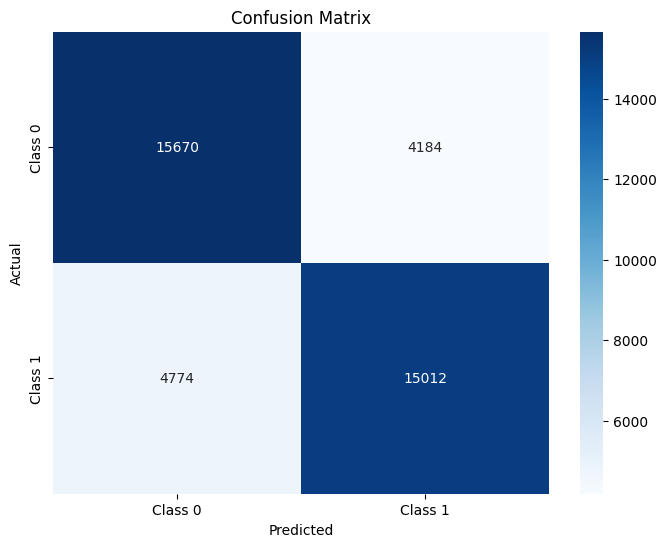

In [30]:
# Example usage
test_model(model, test_loader)

# Save model

In [31]:
# Save the best model weights
torch.save(model.state_dict(), 'model_weights.pth')

# Save the model architecture and parameters
torch.save({
    'input_dim': input_dim,
    'hidden_dim': hidden_dim,
    'output_dim': output_dim,
    'num_layers': num_layers,
    'dropout': dropout,
    'state_dict': model.state_dict()
}, 'model_checkpoint.pth')
